# ICT4SM GOUP 14 LAB 2

In [89]:
import pymongo as pm 

client = pm.MongoClient('bigdatadb.polito.it:27017',
                        ssl=True,
                        authSource = 'carsharing',
                        username = 'ictts',
                        password ='Ict4SM22!',
                        tlsAllowInvalidCertificates=True)

db_car2go = client["carsharing"]["ictts_PermanentBookings"]
db_enjoy = client["carsharing"]["ictts_enjoy_PermanentBookings"]

## Tasks

### 1 For carsharing data, check if the booking records requires to be filtered to get valid rentals. Derive the OD matrix based on the zones of Torino

Filtering function

In [90]:
import pandas as pd
from tqdm import tqdm

# Fetch data in small batches with progress tracking
def fetch_all_data_in_batches(collection, collection_name, batch_size=10000):
    cursor = collection.find({}, {"init_loc": 1, "final_loc": 1, "driving.duration": 1, "init_time": 1}, no_cursor_timeout=True)
    with tqdm(desc=f"Fetching {collection_name} data", unit="records") as pbar:
        try:
            batch_data = []
            for document in cursor:
                batch_data.append(document)
                pbar.update(1)
                if len(batch_data) >= batch_size:
                    yield pd.DataFrame(batch_data)
                    batch_data = []
            if batch_data:
                yield pd.DataFrame(batch_data)
        finally:
            cursor.close()

# Filter valid rentals (init_loc and final_loc must be distinct, duration in IQR)
def filter_valid_rentals(df):
    # Extract driving durations
    df["driving_duration"] = df["driving"].apply(lambda x: x["duration"] if x else None)
    
    # Calculate Q1 and Q3 for driving durations
    Q1 = df["driving_duration"].quantile(0.25)
    Q3 = df["driving_duration"].quantile(0.75)
    
    # Filter rows
    return df[
        (df["driving_duration"] >= Q1) & 
        (df["driving_duration"] <= Q3) & 
        (df["init_loc"].apply(lambda x: tuple(x["coordinates"])) != df["final_loc"].apply(lambda x: tuple(x["coordinates"])))
    ]

# Process batches and filter data locally
def process_filtered_data(collection, collection_name):
    all_filtered_batches = []

    for batch in fetch_all_data_in_batches(collection, collection_name):
        filtered_batch = filter_valid_rentals(batch)
        all_filtered_batches.append(filtered_batch)

    # Combine all filtered batches into a single df
    if all_filtered_batches:
        final_filtered_data = pd.concat(all_filtered_batches, ignore_index=True)
        print(f"Processed data from {collection_name} locally.")
        return final_filtered_data
    else:
        print(f"No valid data found for {collection_name}.")
        return pd.DataFrame()

car2go = process_filtered_data(db_car2go, "Car2GO")
enjoy = process_filtered_data(db_enjoy, "Enjoy")

C:\Users\sartr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pymongo\synchronous\collection.py:1920: UserWarning: use an explicit session with no_cursor_timeout=True otherwise the cursor may still timeout after 30 minutes, for more info see https://mongodb.com/docs/v4.4/reference/method/cursor.noCursorTimeout/#session-idle-timeout-overrides-nocursortimeout
  return Cursor(self, *args, **kwargs)


Processing Car2GO data...


Fetching Car2GO data: 121667records [00:05, 21468.52records/s]
C:\Users\sartr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pymongo\synchronous\collection.py:1920: UserWarning: use an explicit session with no_cursor_timeout=True otherwise the cursor may still timeout after 30 minutes, for more info see https://mongodb.com/docs/v4.4/reference/method/cursor.noCursorTimeout/#session-idle-timeout-overrides-nocursortimeout
  return Cursor(self, *args, **kwargs)


Processed data from Car2GO locally.
Processing Enjoy data...


Fetching Enjoy data: 97173records [00:02, 37680.59records/s]

Processed data from Enjoy locally.
Filtered Car2GO Data:
                        _id  \
0  5a3bb3af20c3dd47cf590056   
1  5a3bb3af20c3dd47cf59005a   
2  5a3bb3af20c3dd47cf590066   
3  5a3bb3af20c3dd47cf590067   
4  5a3bb3af20c3dd47cf590068   

                                           final_loc   init_time  \
0  {'coordinates': [7.67356, 45.07047], 'type': '...  1509490211   
1  {'coordinates': [7.65304, 45.06744], 'type': '...  1509490067   
2  {'coordinates': [7.65199, 45.07869], 'type': '...  1509489771   
3  {'coordinates': [7.65937, 45.04402], 'type': '...  1509489723   
4  {'coordinates': [7.68186, 45.05578], 'type': '...  1509489674   

                                            init_loc           driving  \
0  {'coordinates': [7.66911, 45.07633], 'type': '...  {'duration': -1}   
1  {'coordinates': [7.64731, 45.06485], 'type': '...  {'duration': -1}   
2  {'coordinates': [7.68693, 45.08535], 'type': '...  {'duration': -1}   
3  {'coordinates': [7.64038, 45.07198], 'type': '..

In [91]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from tqdm import tqdm  # Progress bar

# Load zones from GeoJSON file
zones = gpd.read_file("./Zone/TorinoZonescol.geojson").to_crs("EPSG:4326")

# Assign zones to trips
def assign_zones(df, zones):
    if "zone_id" not in zones.columns:
        zones["zone_id"] = range(len(zones))

    try:
        # Assign ORI_ZONE
        print("Assigning ORI_ZONE...")
        df["ORI_ZONE"] = gpd.sjoin(
            gpd.GeoDataFrame(df, geometry=df["init_loc"].apply(lambda loc: Point(*loc['coordinates'])), crs="EPSG:4326"),
            zones, how="left", predicate="intersects"
        )["zone_id"]

        # Assign DST_ZONE
        print("Assigning DST_ZONE...")
        df["DST_ZONE"] = gpd.sjoin(
            gpd.GeoDataFrame(df, geometry=df["final_loc"].apply(lambda loc: Point(*loc['coordinates'])), crs="EPSG:4326"),
            zones, how="left", predicate="intersects"
        )["zone_id"]

        # Drop rows with missing ORI_ZONE or DST_ZONE
        df = df.dropna(subset=["ORI_ZONE", "DST_ZONE"]).reset_index(drop=True)

        print(f"Rows after dropping NaNs: {len(df)}")
        return df

    except Exception as e:
        print("Error during zone assignment:", e)
        raise

# Add hour, day, and date columns based on init_time
def add_time_columns(df):
    df["hour"] = pd.to_datetime(df["init_time"], unit="s", errors="coerce").dt.hour
    df["day"] = pd.to_datetime(df["init_time"], unit="s", errors="coerce").dt.weekday
    df["date"] = pd.to_datetime(df["init_time"], unit="s", errors="coerce").dt.date
    return df

# Generate OD matrix
def generate_od_matrix(df, zones):
    df_with_zones = assign_zones(df, zones)
    if df_with_zones.empty:
        return pd.DataFrame()
    df_with_zones = add_time_columns(df_with_zones)

    # Group
    od_matrix = df_with_zones.groupby(["ORI_ZONE", "DST_ZONE", "hour", "day", "date"]).size().reset_index(name="count")

    return od_matrix

def process_and_save_matrices(df, zones, output_file):
    od_matrix = generate_od_matrix(df, zones)
    od_matrix.to_csv(output_file, index=False)


process_and_save_matrices(car2go, zones, "car2go_od_matrix.csv")
process_and_save_matrices(enjoy, zones, "enjoy_od_matrix.csv")



Processing Car2GO data...
Assigning zones...
Assigning ORI_ZONE...
Assigning DST_ZONE...
ORI_ZONE NaN count: 594
DST_ZONE NaN count: 477
Rows after dropping NaNs: 90506
Adding time columns...
Columns in processed DataFrame: Index(['_id', 'final_loc', 'init_time', 'init_loc', 'driving',
       'driving_duration', 'ORI_ZONE', 'DST_ZONE', 'hour', 'day', 'date'],
      dtype='object')
Sample rows:
                         _id  \
0  5a3bb3af20c3dd47cf590056   
1  5a3bb3af20c3dd47cf59005a   
2  5a3bb3af20c3dd47cf590066   
3  5a3bb3af20c3dd47cf590067   
4  5a3bb3af20c3dd47cf590068   

                                           final_loc   init_time  \
0  {'coordinates': [7.67356, 45.07047], 'type': '...  1509490211   
1  {'coordinates': [7.65304, 45.06744], 'type': '...  1509490067   
2  {'coordinates': [7.65199, 45.07869], 'type': '...  1509489771   
3  {'coordinates': [7.65937, 45.04402], 'type': '...  1509489723   
4  {'coordinates': [7.68186, 45.05578], 'type': '...  1509489674   

      

### a. Compute OD matrices on different periods (weekdays vs weekends, daytime vs night-time). Is it possible to spot any difference? 

Plotting Car2GO OD matrices for different periods...


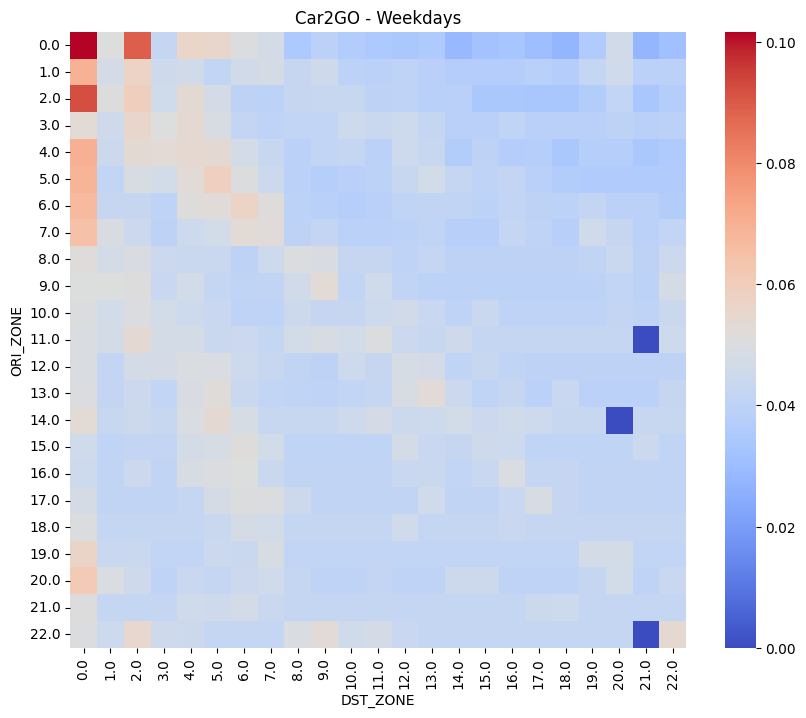

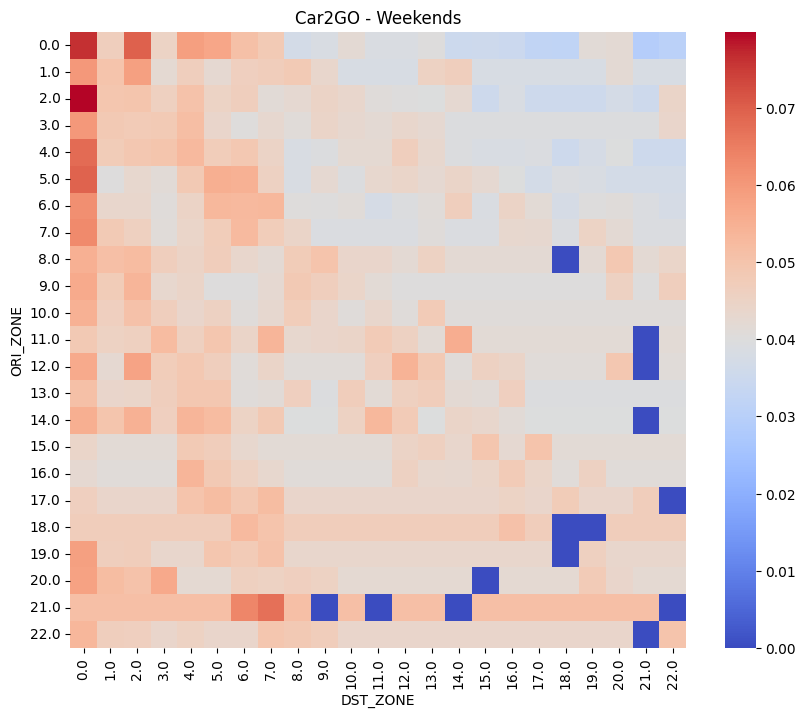

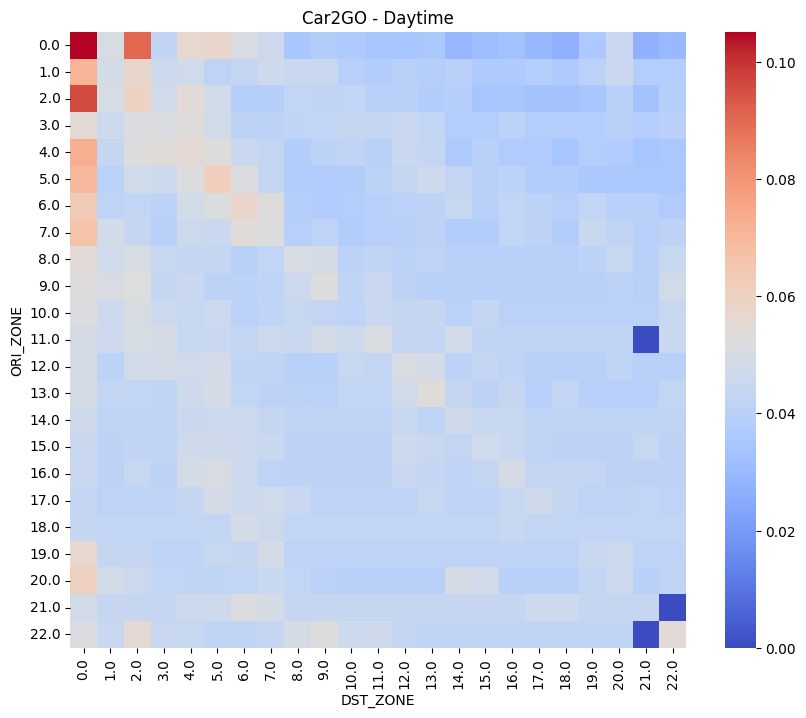

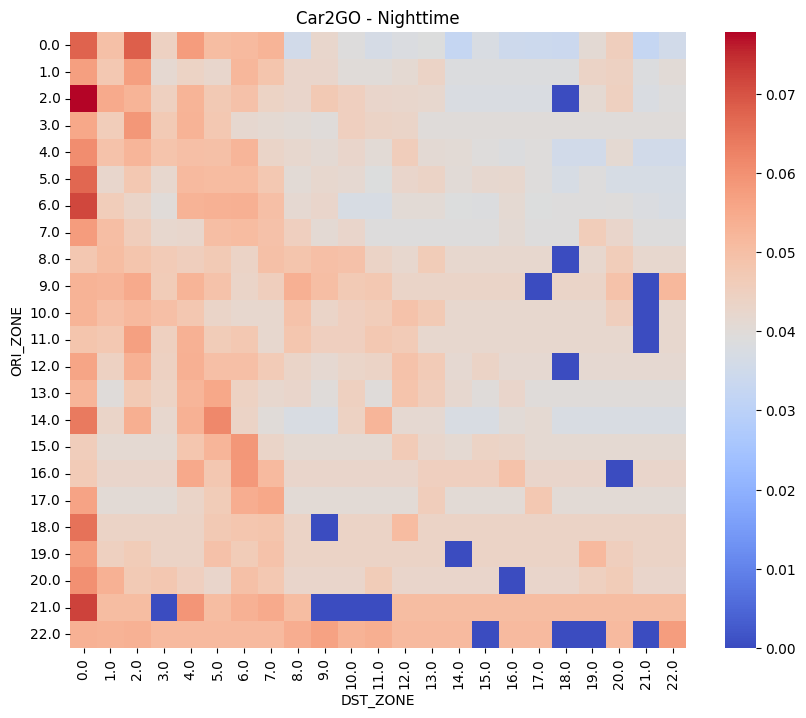

Plotting Car2GO OD matrices for same period different weeks...


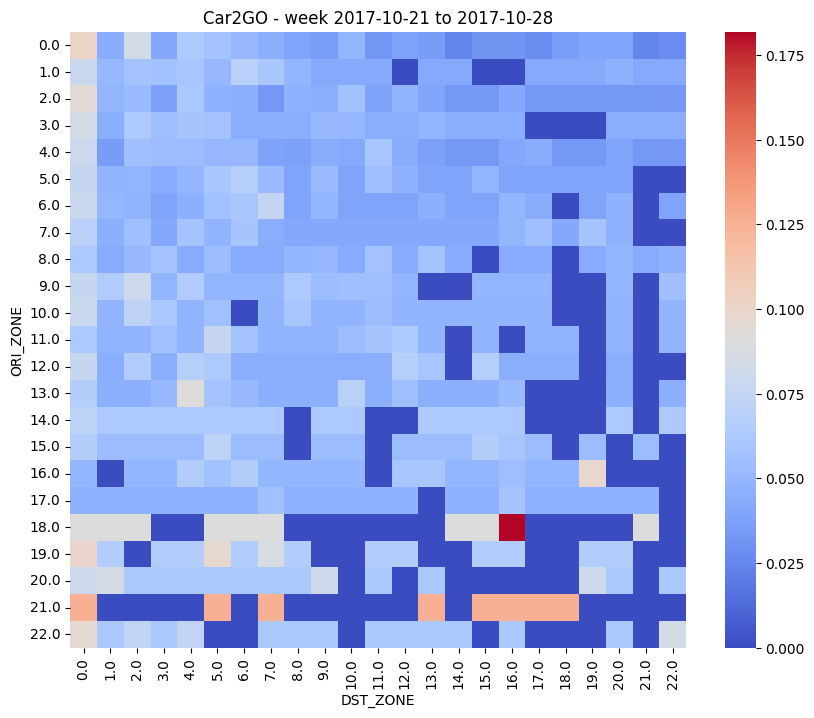

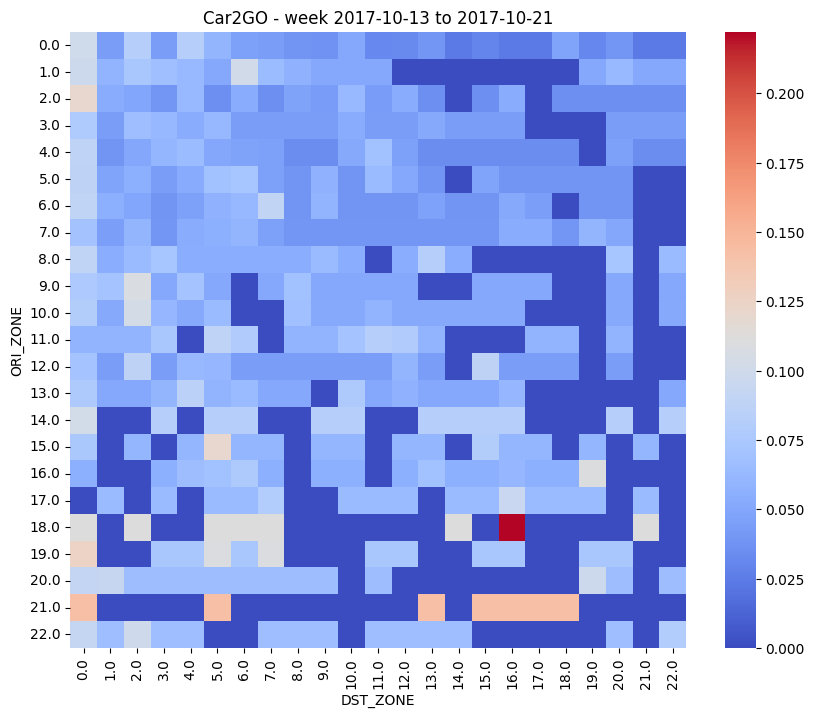

Plotting comparison between Car2GO and Enjoy...


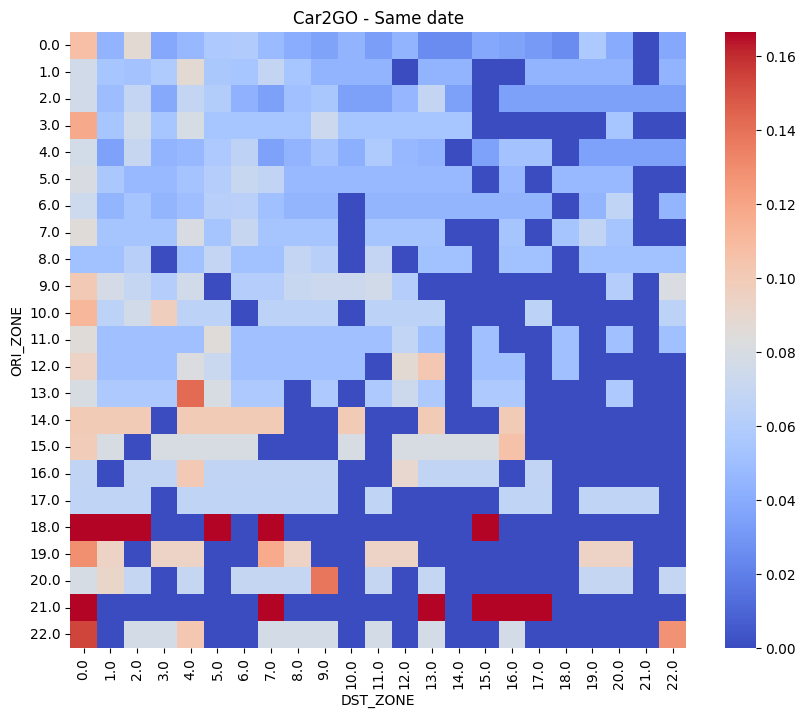

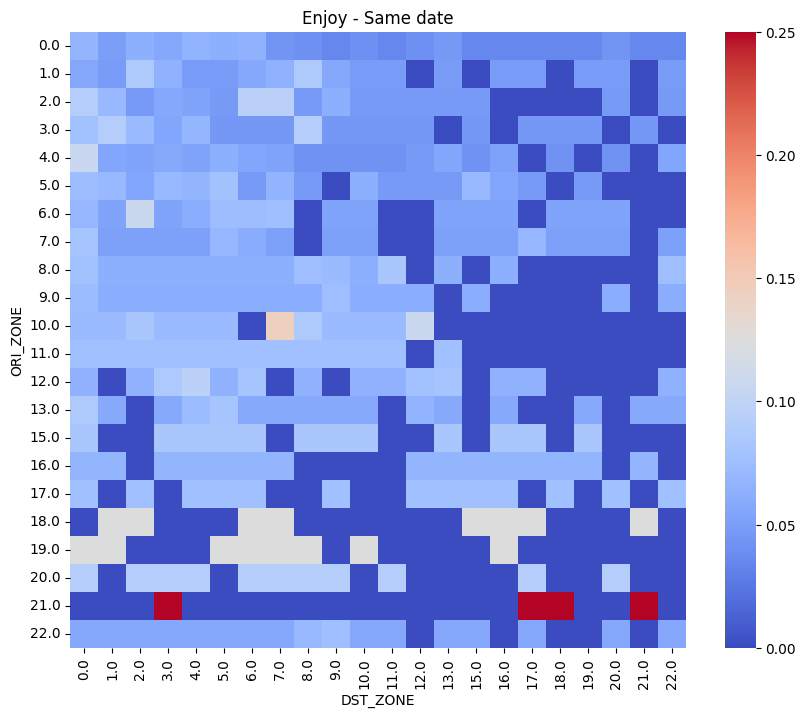

In [94]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def filter_od_matrix(df, day_filter=None, hour_filter=None, date_filter=None):
    if day_filter is not None:
        df = df[df["day"].isin(day_filter)]
    if hour_filter is not None:
        if hour_filter[0] < hour_filter[1]:  # Normal 6:00 to 18:00
            df = df[(df["hour"] >= hour_filter[0]) & (df["hour"] < hour_filter[1])]
        else:  # Overnight 18:00 to 6:00
            df = df[(df["hour"] >= hour_filter[0]) | (df["hour"] < hour_filter[1])]
    if date_filter is not None:
        df = df[(pd.to_datetime(df["date"]).isin(pd.to_datetime(date_filter)))]
    return df

def normalize_od_matrix(df):
    pivot = df.pivot_table(index="ORI_ZONE", columns="DST_ZONE", values="count", fill_value=0)
    row_sums = pivot.sum(axis=1).replace(0, np.nan)  # Avoid division by zero
    normalized_matrix = pivot.div(row_sums, axis=0).fillna(0)
    
    return normalized_matrix


def plot_od_matrix(df, title):
    if df.empty:
        print(f"No data available for {title}. Skipping plot.")
        return

    # Normalize the OD matrix before plotting
    normalized_matrix = normalize_od_matrix(df)

    plt.figure(figsize=(10, 8))
    sns.heatmap(normalized_matrix, cmap="coolwarm", square=True, cbar=True)
    plt.title(title)
    plt.xlabel("DST_ZONE")
    plt.ylabel("ORI_ZONE")
    plt.show()

# Load OD matrices
car2go_od_matrix = pd.read_csv("car2go_od_matrix.csv")
enjoy_od_matrix = pd.read_csv("enjoy_od_matrix.csv")

#Compute OD matrices for different periods (weekdays vs weekends, daytime vs nighttime)
print("Plotting Car2GO OD matrices for different periods...")
weekday_od = filter_od_matrix(car2go_od_matrix, day_filter=range(0, 5))
plot_od_matrix(weekday_od, "Car2GO - Weekdays")

weekend_od = filter_od_matrix(car2go_od_matrix, day_filter=[5, 6])
plot_od_matrix(weekend_od, "Car2GO - Weekends")

daytime_od = filter_od_matrix(car2go_od_matrix, hour_filter=(6, 18))
plot_od_matrix(daytime_od, "Car2GO - Daytime")

nighttime_od = filter_od_matrix(car2go_od_matrix, hour_filter=(18, 6))
plot_od_matrix(nighttime_od, "Car2GO - Nighttime")

# Compute OD matrices for same period (weekdays but different weeks)
print("Plotting Car2GO OD matrices for same period different weeks...")
week1_dates = ['2017-10-21', '2017-10-28']
week2_dates = ['2017-10-13', '2017-10-21']
week1_od = filter_od_matrix(car2go_od_matrix, day_filter=[0, 5], date_filter=week1_dates)
week2_od = filter_od_matrix(car2go_od_matrix, day_filter=[0, 5], date_filter=week2_dates)

plot_od_matrix(week1_od, "Car2GO - week 2017-10-21 to 2017-10-28")
plot_od_matrix(week2_od, "Car2GO - week 2017-10-13 to 2017-10-21")

# Compare OD matrices for the same date between Car2GO and Enjoy
print("Plotting comparison between Car2GO and Enjoy...")
same_date = ['2017-10-28']
same_date_car2go = filter_od_matrix(car2go_od_matrix, date_filter=same_date)
same_date_enjoy = filter_od_matrix(enjoy_od_matrix, date_filter=same_date)

plot_od_matrix(same_date_car2go, "Car2GO - Same date")
plot_od_matrix(same_date_enjoy, "Enjoy - Same date")


### b. Consider the same period, compute OD matrices on different dates (e.g., OD matrices of weekdays in two different weeks). is it possible to spot any difference? How does the different compare with different periods? 

### c. Consider the same period, compute OD matrices on same date for Car2GO and Enjoy. Is there any difference between different platforms? How does it compare with previous ones? 

## 2. Derive metrics to compute the similarity between OD matrices.

In [98]:
import pandas as pd
import numpy as np

def normalize_and_align(df, zones):
    """
    Normalize the OD matrix and align it to shared zones.
    """
    pivot = df.pivot_table(index="ORI_ZONE", columns="DST_ZONE", values="count", fill_value=0)
    row_sums = pivot.sum(axis=1).replace(0, np.nan)  # Avoid division by zero
    normalized_matrix = pivot.div(row_sums, axis=0).fillna(0)

    # Align to the provided zones
    aligned_matrix = normalized_matrix.reindex(index=zones, columns=zones, fill_value=0)
    return aligned_matrix

def compute_similarity_metrics(matrix_a, matrix_b):
    """
    Compute similarity metrics between two OD matrices.
    """
    # Ensure alignment
    shared_zones = sorted(set(matrix_a.index).intersection(matrix_b.index))
    matrix_a = matrix_a.loc[shared_zones, shared_zones]
    matrix_b = matrix_b.loc[shared_zones, shared_zones]

    a_flat = matrix_a.values.flatten()
    b_flat = matrix_b.values.flatten()

    # Compute metrics
    absolute_difference = np.sum(np.abs(a_flat - b_flat))
    mse = np.mean((a_flat - b_flat) ** 2)
    rmse = np.sqrt(mse)

    return {
        "Absolute Difference": absolute_difference,
        "Mean Squared Error": mse,
        "Root Mean Squared Error": rmse
    }

# Load OD matrices
car2go_od_matrix = pd.read_csv("car2go_od_matrix.csv")
enjoy_od_matrix = pd.read_csv("enjoy_od_matrix.csv")

# Define the set of zones
zones = sorted(set(car2go_od_matrix["ORI_ZONE"]).union(car2go_od_matrix["DST_ZONE"]))

# Weekdays vs Weekends
weekday_od = car2go_od_matrix[car2go_od_matrix["day"].isin(range(0, 5))]
weekend_od = car2go_od_matrix[car2go_od_matrix["day"].isin([5, 6])]
weekday_normalized = normalize_and_align(weekday_od, zones)
weekend_normalized = normalize_and_align(weekend_od, zones)
similarity_weekday_weekend = compute_similarity_metrics(weekday_normalized, weekend_normalized)
print("Similarity between Weekdays and Weekends:")
for metric, value in similarity_weekday_weekend.items():
    print(f"  {metric}: {value:.4f}")

# Daytime vs Nighttime
daytime_od = car2go_od_matrix[(car2go_od_matrix["hour"] >= 6) & (car2go_od_matrix["hour"] < 18)]
nighttime_od = car2go_od_matrix[(car2go_od_matrix["hour"] >= 18) | (car2go_od_matrix["hour"] < 6)]
daytime_normalized = normalize_and_align(daytime_od, zones)
nighttime_normalized = normalize_and_align(nighttime_od, zones)
similarity_daytime_nighttime = compute_similarity_metrics(daytime_normalized, nighttime_normalized)
print("Similarity between Daytime and Nighttime:")
for metric, value in similarity_daytime_nighttime.items():
    print(f"  {metric}: {value:.4f}")

# Week 1 vs Week 2
week1_dates = ['2017-10-21', '2017-10-28']
week2_dates = ['2017-10-13', '2017-10-20']
week1_od = car2go_od_matrix[car2go_od_matrix["date"].isin(week1_dates)]
week2_od = car2go_od_matrix[car2go_od_matrix["date"].isin(week2_dates)]
week1_normalized = normalize_and_align(week1_od, zones)
week2_normalized = normalize_and_align(week2_od, zones)
similarity_weeks = compute_similarity_metrics(week1_normalized, week2_normalized)
print("Similarity between Week 1 and Week 2:")
for metric, value in similarity_weeks.items():
    print(f"  {metric}: {value:.4f}")

# Car2GO vs Enjoy on the same date
same_date = ['2017-10-28']
same_date_car2go = car2go_od_matrix[car2go_od_matrix["date"].isin(same_date)]
same_date_enjoy = enjoy_od_matrix[enjoy_od_matrix["date"].isin(same_date)]
car2go_normalized = normalize_and_align(same_date_car2go, zones)
enjoy_normalized = normalize_and_align(same_date_enjoy, zones)
similarity_car2go_enjoy = compute_similarity_metrics(car2go_normalized, enjoy_normalized)
print("Similarity between Car2GO and Enjoy on the same date:")
for metric, value in similarity_car2go_enjoy.items():
    print(f"  {metric}: {value:.4f}")

# Two random matrices
random_matrix_1 = car2go_od_matrix.sample(frac=1).reset_index(drop=True)
random_matrix_2 = enjoy_od_matrix.sample(frac=1).reset_index(drop=True)
random_matrix_1_normalized = normalize_and_align(random_matrix_1, zones)
random_matrix_2_normalized = normalize_and_align(random_matrix_2, zones)
similarity_random = compute_similarity_metrics(random_matrix_1_normalized, random_matrix_2_normalized)
print("Similarity between two random matrices:")
for metric, value in similarity_random.items():
    print(f"  {metric}: {value:.4f}")

# Enjoy (same day) vs Car2GO (weekdays)
similarity_enjoy_car2go_weekdays = compute_similarity_metrics(enjoy_normalized, weekday_normalized)
print("Similarity between Enjoy (same day) and Car2GO (weekdays):")
for metric, value in similarity_enjoy_car2go_weekdays.items():
    print(f"  {metric}: {value:.4f}")


Similarity between Weekdays and Weekends:
  Absolute Difference: 1.9930
  Mean Squared Error: 0.0001
  Root Mean Squared Error: 0.0077
Similarity between Daytime and Nighttime:
  Absolute Difference: 2.3921
  Mean Squared Error: 0.0001
  Root Mean Squared Error: 0.0090
Similarity between Week 1 and Week 2:
  Absolute Difference: 9.1806
  Mean Squared Error: 0.0009
  Root Mean Squared Error: 0.0297
Similarity between Car2GO and Enjoy on the same date:
  Absolute Difference: 15.3401
  Mean Squared Error: 0.0023
  Root Mean Squared Error: 0.0478
Similarity between two random matrices:
  Absolute Difference: 3.3900
  Mean Squared Error: 0.0003
  Root Mean Squared Error: 0.0172
Similarity between Enjoy (same day) and Car2GO (weekdays):
  Absolute Difference: 16.5120
  Mean Squared Error: 0.0015
  Root Mean Squared Error: 0.0391


## 3. Compute OD matrices for unipol and IMQ

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

def data_preprocessing():
    # Load UnipolTech data
    info_to = pd.read_csv('./Info_TO.csv')  # Replace with actual path
    trips_od_to = pd.read_csv('./Trips_OD_TO.csv')  # Replace with actual path
    zones = gpd.read_file('./Zone/TorinoZonescol.geojson')  # Replace with actual path to zones file
    
    # Merge UnipolTech datasets
    unipol_merged = pd.merge(trips_od_to, info_to, on='id_veicolo')
    
    # Assign zones
    unipol_merged = assign_zones(unipol_merged, zones)
    
    # Extract hour and day from start time
    unipol_merged["hour"] = pd.to_datetime(unipol_merged["istante_start"], errors="coerce").dt.hour
    unipol_merged["day"] = pd.to_datetime(unipol_merged["istante_start"], errors="coerce").dt.dayofweek
    
    # Load IMQ data
    imq_data = pd.read_csv('./IMQData_Torino.csv')  # Replace with actual path
    
    # Extract hour and day from DEP_HOUR
    imq_data["hour"] = imq_data["DEP_HOUR"].str.extract(r'(\d{2}):\d{2}:\d{2}')[0].astype(int)
    imq_data["day"] = pd.to_datetime(imq_data["DEP_HOUR"], errors="coerce").dt.dayofweek
    
    # Modify ORI_ZONE and DST_ZONE to keep only the numeric portions
    imq_data["ORI_ZONE"] = imq_data["ORI_ZONE"].str.extract(r'(\d+)$').astype(int)
    imq_data["DST_ZONE"] = imq_data["DST_ZONE"].str.extract(r'(\d+)$').astype(int)
    
    # Print first few rows of each DataFrame
    print("UnipolTech Data:")
    print(unipol_merged.head())
    print("\nIMQ Data:")
    print(imq_data.head())
    
    return imq_data, unipol_merged

def assign_zones(df, zones):
    """
    Assign ORI_ZONE and DST_ZONE based on spatial joins with zones.
    """
    if "zone_id" not in zones.columns:
        zones["zone_id"] = range(len(zones))
    
    # Convert start locations to GeoDataFrame for ORI_ZONE
    df["ORI_ZONE"] = gpd.sjoin(
        gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["lon_start"], df["lat_start"]), crs="EPSG:4326"),
        zones, how="left", predicate="intersects"
    )["zone_id"]
    
    # Convert end locations to GeoDataFrame for DST_ZONE
    df["DST_ZONE"] = gpd.sjoin(
        gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["lon_stop"], df["lat_stop"]), crs="EPSG:4326"),
        zones, how="left", predicate="intersects"
    )["zone_id"]
    
    return df.dropna(subset=["ORI_ZONE", "DST_ZONE"]).reset_index(drop=True)

# Call the function and get the preprocessed data
imq_data, unipol_merged = data_preprocessing()


UnipolTech Data:
   id_veicolo  id_viaggio        istante_start  lat_start  lon_start  \
0           1           2  2024-08-27 21:15:03     45.069      7.698   
1           1           4  2024-08-27 21:22:47     45.069      7.698   
2           1           5  2024-08-28 08:16:42     45.083      7.675   
3           1           6  2024-08-28 11:47:37     45.068      7.687   
4           1           7  2024-08-29 12:22:22     45.083      7.675   

          istante_stop  lat_stop  lon_stop commerciale  eta_approx genere  \
0  2024-08-27 21:16:05    45.069     7.698           N          47      M   
1  2024-08-27 21:32:03    45.083     7.675           N          47      M   
2  2024-08-28 08:29:07    45.067     7.688           N          47      M   
3  2024-08-28 11:54:02    45.083     7.675           N          47      M   
4  2024-08-29 12:31:44    45.077     7.668           N          47      M   

   ORI_ZONE  DST_ZONE  hour  day  
0       7.0       7.0    21    1  
1       7.0      

C:\Users\sartr\AppData\Local\Temp\ipykernel_24356\4220505589.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  imq_data["day"] = pd.to_datetime(imq_data["DEP_HOUR"], errors="coerce").dt.dayofweek


C:\Users\sartr\AppData\Local\Temp\ipykernel_24356\4220505589.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  imq_data["day"] = pd.to_datetime(imq_data["DEP_HOUR"], errors="coerce").dt.dayofweek


UnipolTech Data:
   id_veicolo  id_viaggio        istante_start  lat_start  lon_start  \
0           1           2  2024-08-27 21:15:03     45.069      7.698   
1           1           4  2024-08-27 21:22:47     45.069      7.698   
2           1           5  2024-08-28 08:16:42     45.083      7.675   
3           1           6  2024-08-28 11:47:37     45.068      7.687   
4           1           7  2024-08-29 12:22:22     45.083      7.675   

          istante_stop  lat_stop  lon_stop commerciale  eta_approx genere  \
0  2024-08-27 21:16:05    45.069     7.698           N          47      M   
1  2024-08-27 21:32:03    45.083     7.675           N          47      M   
2  2024-08-28 08:29:07    45.067     7.688           N          47      M   
3  2024-08-28 11:54:02    45.083     7.675           N          47      M   
4  2024-08-29 12:31:44    45.077     7.668           N          47      M   

   ORI_ZONE  DST_ZONE  hour  day  
0       7.0       7.0    21    1  
1       7.0      

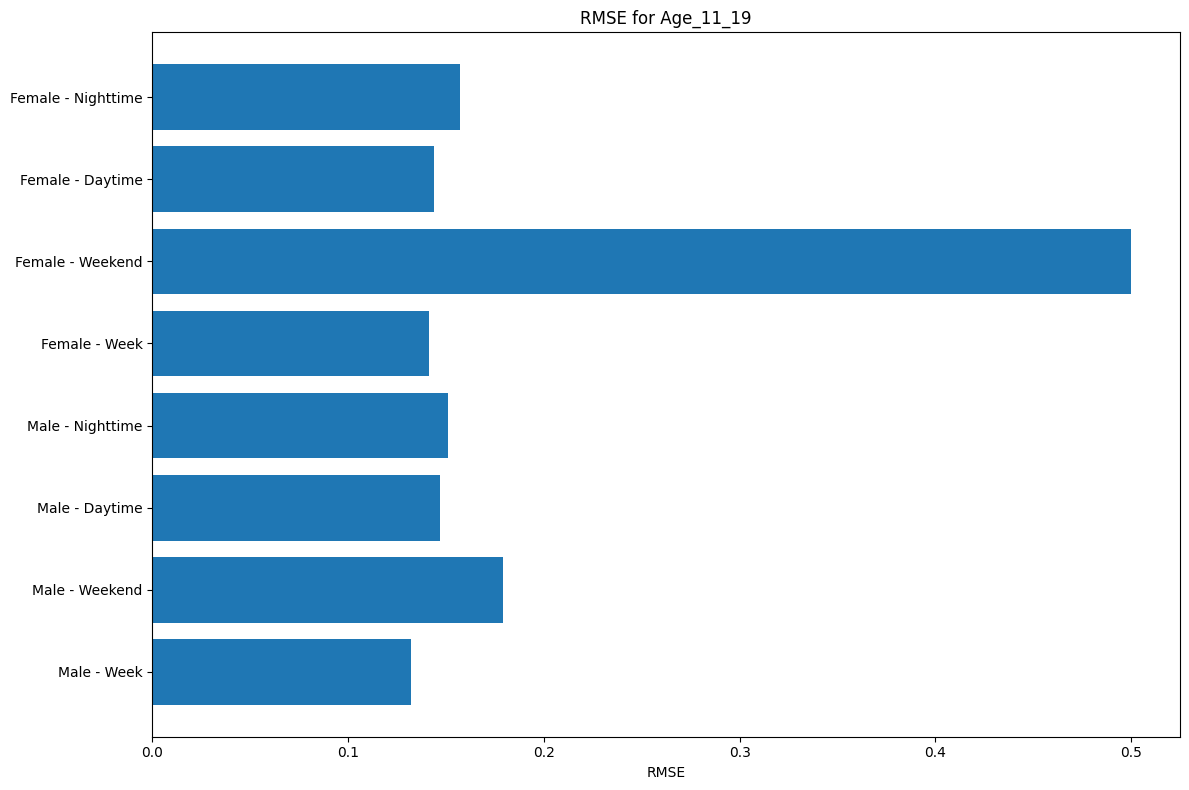

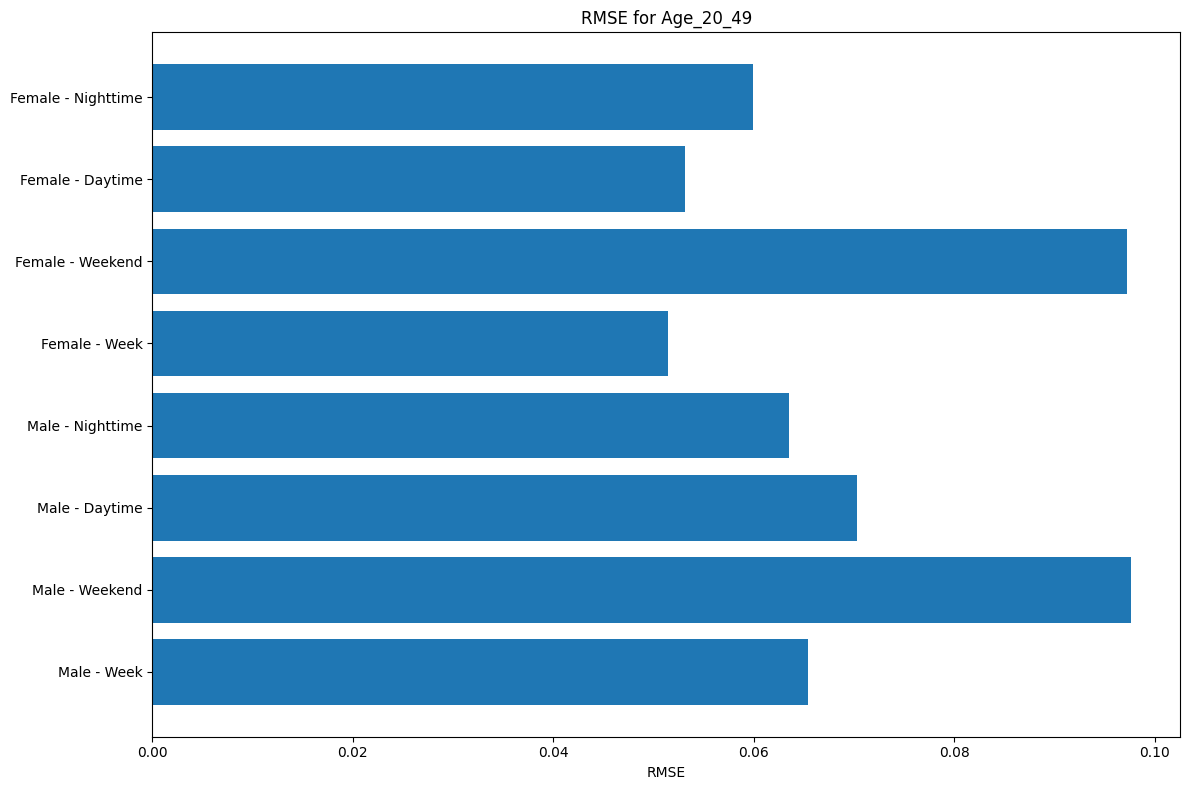

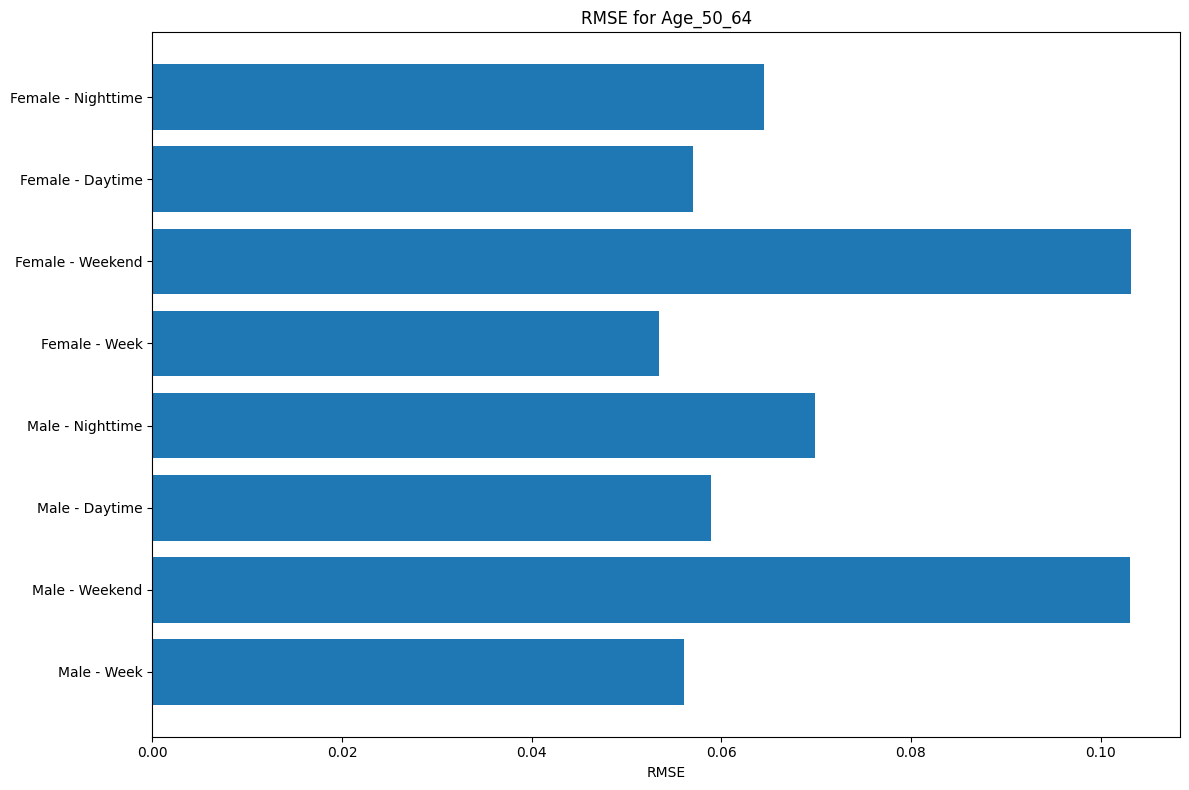

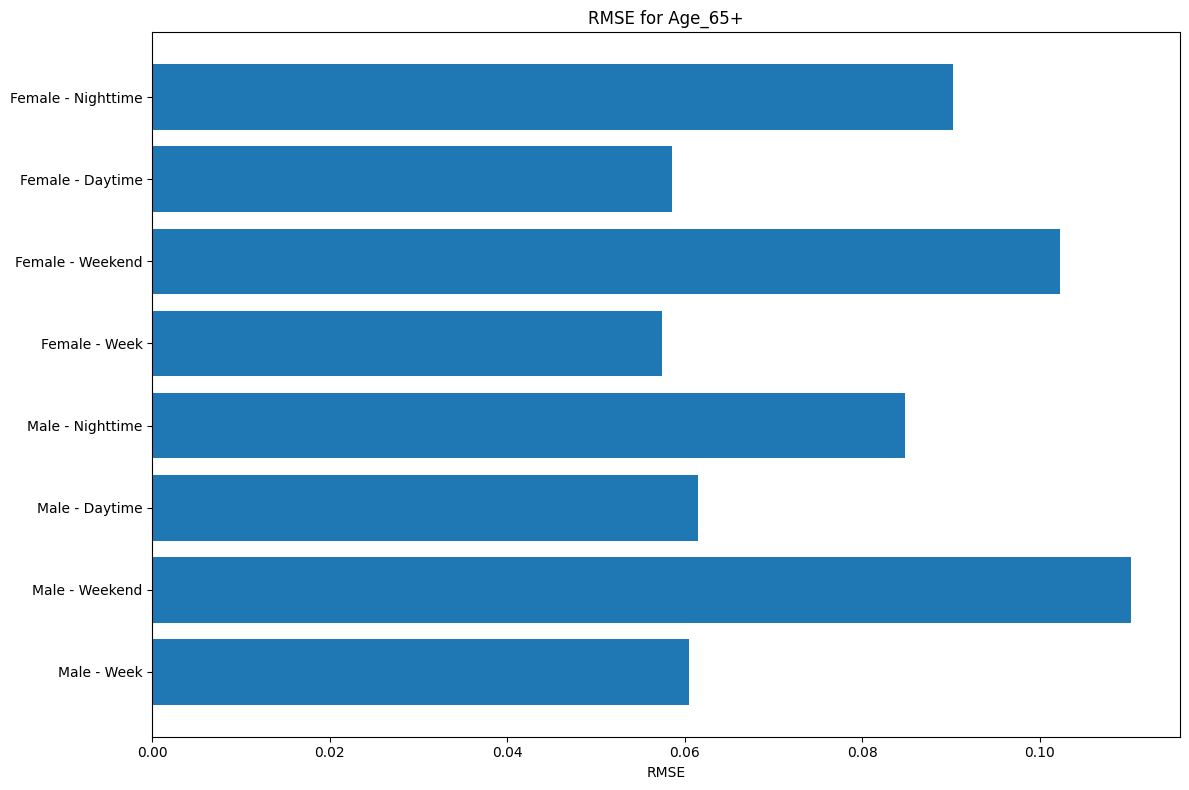

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Helper function to filter data based on conditions
def filter_od_matrix(df, day_filter=None, hour_filter=None):
    if day_filter is not None:
        df = df[df["day"].isin(day_filter)]
    if hour_filter is not None:
        if hour_filter[0] < hour_filter[1]:  # Normal case, e.g., 7:00 to 18:00
            df = df[(df["hour"] >= hour_filter[0]) & (df["hour"] < hour_filter[1])]
        else:  # Overnight case, e.g., 18:00 to 7:00
            df = df[(df["hour"] >= hour_filter[0]) | (df["hour"] < hour_filter[1])]
    return df

# Function to compute OD matrix
def compute_od_matrix(df, origin_col, destination_col):
    od_matrix = df.groupby([origin_col, destination_col]).size().unstack(fill_value=0)
    row_sums = od_matrix.sum(axis=1).replace(0, 1)  # Avoid division by zero
    return od_matrix.div(row_sums, axis=0)

# Function to calculate RMSE similarity
def compute_rmse(matrix_a, matrix_b):
    zones = sorted(set(matrix_a.index).union(set(matrix_b.index)))
    matrix_a = matrix_a.reindex(index=zones, columns=zones, fill_value=0)
    matrix_b = matrix_b.reindex(index=zones, columns=zones, fill_value=0)
    return np.sqrt(np.mean((matrix_a.values - matrix_b.values) ** 2))

# Preprocessing to get IMQ and Unipol data
imq_data, unipol_merged = data_preprocessing()

# Define age and gender groups for both datasets
groups = {
    "Age_11_19": {
        "Male": {
            "imq": imq_data[(imq_data["GENDER"] == 1) & (imq_data["AGE"] == 1)],
            "unipol": unipol_merged[(unipol_merged["genere"] == "M") & (unipol_merged["eta_approx"] >= 11) & (unipol_merged["eta_approx"] <= 19)],
        },
        "Female": {
            "imq": imq_data[(imq_data["GENDER"] == 2) & (imq_data["AGE"] == 1)],
            "unipol": unipol_merged[(unipol_merged["genere"] == "F") & (unipol_merged["eta_approx"] >= 11) & (unipol_merged["eta_approx"] <= 19)],
        },
    },
    "Age_20_49": {
        "Male": {
            "imq": imq_data[(imq_data["GENDER"] == 1) & (imq_data["AGE"] == 2)],
            "unipol": unipol_merged[(unipol_merged["genere"] == "M") & (unipol_merged["eta_approx"] >= 20) & (unipol_merged["eta_approx"] <= 49)],
        },
        "Female": {
            "imq": imq_data[(imq_data["GENDER"] == 2) & (imq_data["AGE"] == 2)],
            "unipol": unipol_merged[(unipol_merged["genere"] == "F") & (unipol_merged["eta_approx"] >= 20) & (unipol_merged["eta_approx"] <= 49)],
        },
    },
    "Age_50_64": {
        "Male": {
            "imq": imq_data[(imq_data["GENDER"] == 1) & (imq_data["AGE"] == 3)],
            "unipol": unipol_merged[(unipol_merged["genere"] == "M") & (unipol_merged["eta_approx"] >= 50) & (unipol_merged["eta_approx"] <= 64)],
        },
        "Female": {
            "imq": imq_data[(imq_data["GENDER"] == 2) & (imq_data["AGE"] == 3)],
            "unipol": unipol_merged[(unipol_merged["genere"] == "F") & (unipol_merged["eta_approx"] >= 50) & (unipol_merged["eta_approx"] <= 64)],
        },
    },
    "Age_65+": {
        "Male": {
            "imq": imq_data[(imq_data["GENDER"] == 1) & (imq_data["AGE"] == 4)],
            "unipol": unipol_merged[(unipol_merged["genere"] == "M") & (unipol_merged["eta_approx"] >= 65)],
        },
        "Female": {
            "imq": imq_data[(imq_data["GENDER"] == 2) & (imq_data["AGE"] == 4)],
            "unipol": unipol_merged[(unipol_merged["genere"] == "F") & (unipol_merged["eta_approx"] >= 65)],
        },
    },
}

# Define conditions
time_filters = {
    "Week": {"day_filter": range(0, 6)},
    "Weekend": {"day_filter": range(6, 8)},
    "Daytime": {"hour_filter": (7, 18)},
    "Nighttime": {"hour_filter": (18, 7)},
}

# Calculate RMSE for all conditions and groups
results = {age_group: [] for age_group in groups.keys()}

for age_group, genders in groups.items():
    for gender, datasets in genders.items():
        for condition, filters in time_filters.items():
            # Filter IMQ and Unipol data
            imq_filtered = filter_od_matrix(datasets["imq"], **filters)
            unipol_filtered = filter_od_matrix(datasets["unipol"], **filters)

            # Compute OD matrices
            imq_od = compute_od_matrix(imq_filtered, "ORI_ZONE", "DST_ZONE")
            unipol_od = compute_od_matrix(unipol_filtered, "ORI_ZONE", "DST_ZONE")

            # Compute RMSE between IMQ and Unipol
            rmse = compute_rmse(imq_od, unipol_od)
            results[age_group].append((f"{gender} - {condition}", rmse))

# Visualize the RMSE values
for age_group, values in results.items():
    labels, rmses = zip(*values)
    plt.figure(figsize=(12, 8))
    plt.barh(labels, rmses)
    plt.xlabel("RMSE")
    plt.title(f"RMSE for {age_group}")
    plt.tight_layout()
    plt.show()


## b. Consider IMQ dataset, what gender of user has greater differences in behaviour across age groups?

UnipolTech Data:
   id_veicolo  id_viaggio        istante_start  lat_start  lon_start  \
0           1           2  2024-08-27 21:15:03     45.069      7.698   
1           1           4  2024-08-27 21:22:47     45.069      7.698   
2           1           5  2024-08-28 08:16:42     45.083      7.675   
3           1           6  2024-08-28 11:47:37     45.068      7.687   
4           1           7  2024-08-29 12:22:22     45.083      7.675   

          istante_stop  lat_stop  lon_stop commerciale  eta_approx genere  \
0  2024-08-27 21:16:05    45.069     7.698           N          47      M   
1  2024-08-27 21:32:03    45.083     7.675           N          47      M   
2  2024-08-28 08:29:07    45.067     7.688           N          47      M   
3  2024-08-28 11:54:02    45.083     7.675           N          47      M   
4  2024-08-29 12:31:44    45.077     7.668           N          47      M   

   ORI_ZONE  DST_ZONE  hour  day  
0       7.0       7.0    21    1  
1       7.0      

C:\Users\sartr\AppData\Local\Temp\ipykernel_24356\4220505589.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  imq_data["day"] = pd.to_datetime(imq_data["DEP_HOUR"], errors="coerce").dt.dayofweek


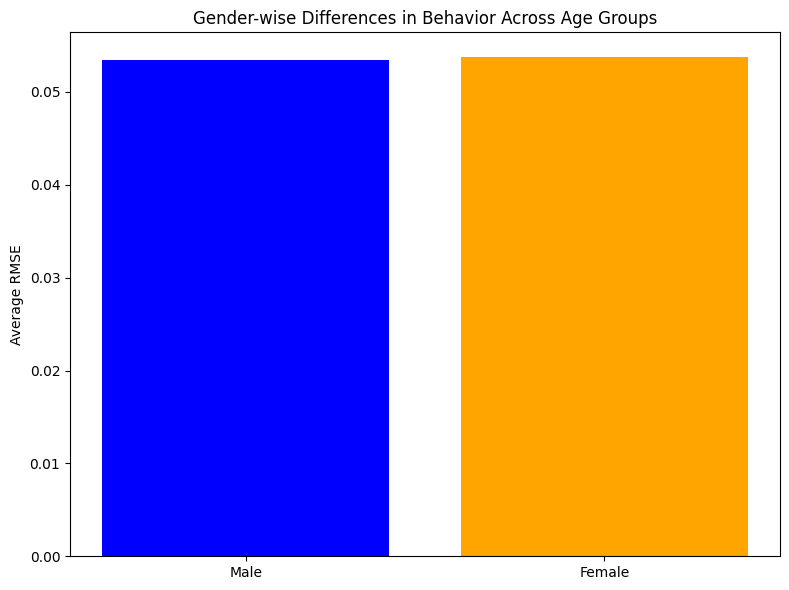

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Helper function to filter data based on conditions
def filter_od_matrix(df, day_filter=None, hour_filter=None):
    if day_filter is not None:
        df = df[df["day"].isin(day_filter)]
    if hour_filter is not None:
        if hour_filter[0] < hour_filter[1]:  # Normal case, e.g., 7:00 to 18:00
            df = df[(df["hour"] >= hour_filter[0]) & (df["hour"] < hour_filter[1])]
        else:  # Overnight case, e.g., 18:00 to 7:00
            df = df[(df["hour"] >= hour_filter[0]) | (df["hour"] < hour_filter[1])]
    return df

# Function to compute OD matrix
def compute_od_matrix(df, origin_col, destination_col):
    od_matrix = df.groupby([origin_col, destination_col]).size().unstack(fill_value=0)
    row_sums = od_matrix.sum(axis=1).replace(0, 1)  # Avoid division by zero
    return od_matrix.div(row_sums, axis=0)

# Function to calculate RMSE similarity
def compute_rmse(matrix_a, matrix_b):
    zones = sorted(set(matrix_a.index).union(set(matrix_b.index)))
    matrix_a = matrix_a.reindex(index=zones, columns=zones, fill_value=0)
    matrix_b = matrix_b.reindex(index=zones, columns=zones, fill_value=0)
    return np.sqrt(np.mean((matrix_a.values - matrix_b.values) ** 2))

# Preprocessing to get IMQ data
imq_data, _ = data_preprocessing()

# Define age groups and genders
gender_groups = {
    "Male": imq_data[imq_data["GENDER"] == 1],
    "Female": imq_data[imq_data["GENDER"] == 2]
}

age_groups = {
    "Age_11_19": 1,
    "Age_20_49": 2,
    "Age_50_64": 3,
    "Age_65+": 4
}

# Compute RMSE for gender differences
rmse_results = {}

for gender, data in gender_groups.items():
    age_matrices = []
    for age_group, age_code in age_groups.items():
        age_data = data[data["AGE"] == age_code]
        od_matrix = compute_od_matrix(age_data, "ORI_ZONE", "DST_ZONE")
        age_matrices.append(od_matrix)

    # Calculate average RMSE across age group matrices
    rmses = []
    for i in range(len(age_matrices)):
        for j in range(i + 1, len(age_matrices)):
            rmses.append(compute_rmse(age_matrices[i], age_matrices[j]))

    rmse_results[gender] = np.mean(rmses) if rmses else np.nan

# Plot the RMSE values
plt.figure(figsize=(8, 6))
plt.bar(rmse_results.keys(), rmse_results.values(), color=['blue', 'orange'])
plt.ylabel("Average RMSE")
plt.title("Gender-wise Differences in Behavior Across Age Groups")
plt.tight_layout()
plt.show()


## Consider IMQ dataset, what kind of users are more likely to use Car2GO and Enjoy?

C:\Users\sartr\AppData\Local\Temp\ipykernel_24356\4220505589.py:26: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  imq_data["day"] = pd.to_datetime(imq_data["DEP_HOUR"], errors="coerce").dt.dayofweek


UnipolTech Data:
   id_veicolo  id_viaggio        istante_start  lat_start  lon_start  \
0           1           2  2024-08-27 21:15:03     45.069      7.698   
1           1           4  2024-08-27 21:22:47     45.069      7.698   
2           1           5  2024-08-28 08:16:42     45.083      7.675   
3           1           6  2024-08-28 11:47:37     45.068      7.687   
4           1           7  2024-08-29 12:22:22     45.083      7.675   

          istante_stop  lat_stop  lon_stop commerciale  eta_approx genere  \
0  2024-08-27 21:16:05    45.069     7.698           N          47      M   
1  2024-08-27 21:32:03    45.083     7.675           N          47      M   
2  2024-08-28 08:29:07    45.067     7.688           N          47      M   
3  2024-08-28 11:54:02    45.083     7.675           N          47      M   
4  2024-08-29 12:31:44    45.077     7.668           N          47      M   

   ORI_ZONE  DST_ZONE  hour  day  
0       7.0       7.0    21    1  
1       7.0      

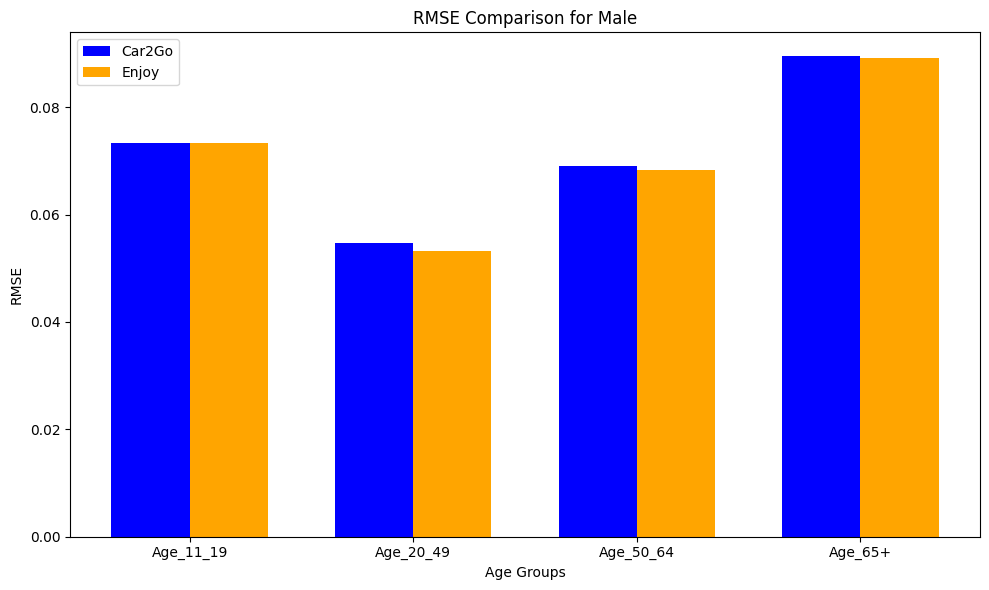

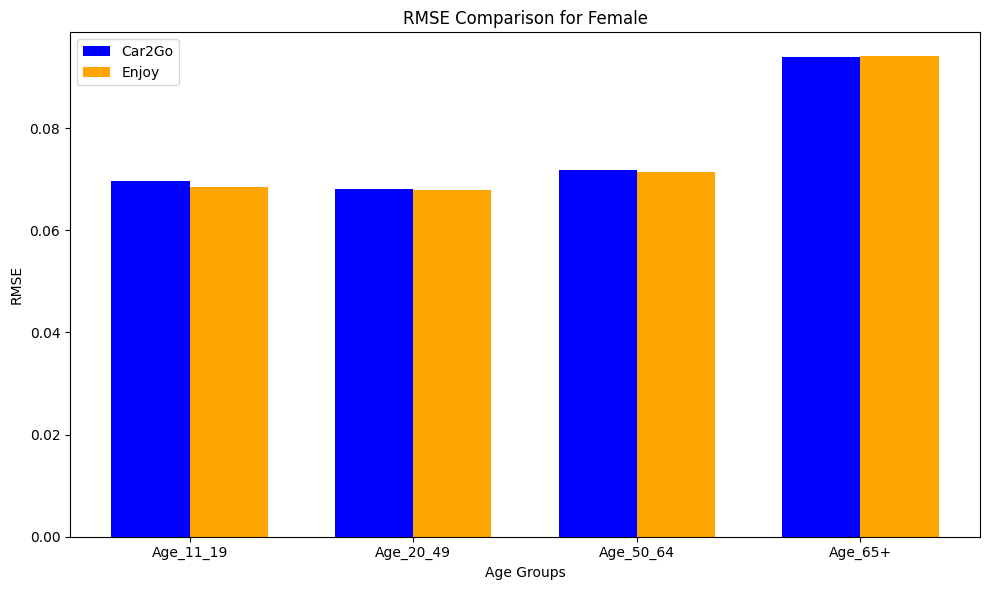

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Helper function to filter data based on conditions
def filter_od_matrix(df, day_filter=None, hour_filter=None):
    if day_filter is not None:
        df = df[df["day"].isin(day_filter)]
    if hour_filter is not None:
        if hour_filter[0] < hour_filter[1]:  # Normal case, e.g., 7:00 to 18:00
            df = df[(df["hour"] >= hour_filter[0]) & (df["hour"] < hour_filter[1])]
        else:  # Overnight case, e.g., 18:00 to 7:00
            df = df[(df["hour"] >= hour_filter[0]) | (df["hour"] < hour_filter[1])]
    return df

# Function to compute OD matrix
def compute_od_matrix(df, origin_col, destination_col):
    od_matrix = df.groupby([origin_col, destination_col]).size().unstack(fill_value=0)
    row_sums = od_matrix.sum(axis=1).replace(0, 1)  # Avoid division by zero
    return od_matrix.div(row_sums, axis=0)

# Function to calculate RMSE similarity
def compute_rmse(matrix_a, matrix_b):
    zones = sorted(set(matrix_a.index).union(set(matrix_b.index)))
    matrix_a = matrix_a.reindex(index=zones, columns=zones, fill_value=0)
    matrix_b = matrix_b.reindex(index=zones, columns=zones, fill_value=0)
    return np.sqrt(np.mean((matrix_a.values - matrix_b.values) ** 2))

# Preprocessing to get IMQ data
imq_data, _ = data_preprocessing()

# Load Car2Go and Enjoy OD matrices
car2go_od_matrix = pd.read_csv("car2go_od_matrix.csv")
enjoy_od_matrix = pd.read_csv("enjoy_od_matrix.csv")

car2go_od_global = compute_od_matrix(car2go_od_matrix, "ORI_ZONE", "DST_ZONE")
enjoy_od_global = compute_od_matrix(enjoy_od_matrix, "ORI_ZONE", "DST_ZONE")

# Define age groups and genders
gender_groups = {
    "Male": imq_data[imq_data["GENDER"] == 1],
    "Female": imq_data[imq_data["GENDER"] == 2]
}

age_groups = {
    "Age_11_19": 1,
    "Age_20_49": 2,
    "Age_50_64": 3,
    "Age_65+": 4
}

# Compute RMSE for IMQ groups against Car2Go and Enjoy
rmse_results = {"Male": [], "Female": []}

for gender, data in gender_groups.items():
    for age_group, age_code in age_groups.items():
        age_data = data[data["AGE"] == age_code]
        imq_od_global = compute_od_matrix(age_data, "ORI_ZONE", "DST_ZONE")

        rmse_car2go = compute_rmse(imq_od_global, car2go_od_global)
        rmse_enjoy = compute_rmse(imq_od_global, enjoy_od_global)

        rmse_results[gender].append((age_group, rmse_car2go, rmse_enjoy))

# Plot the RMSE values
for gender, values in rmse_results.items():
    age_groups, rmse_car2go, rmse_enjoy = zip(*values)

    x = np.arange(len(age_groups))
    width = 0.35

    plt.figure(figsize=(10, 6))
    plt.bar(x - width/2, rmse_car2go, width, label="Car2Go", color="blue")
    plt.bar(x + width/2, rmse_enjoy, width, label="Enjoy", color="orange")

    plt.xlabel("Age Groups")
    plt.ylabel("RMSE")
    plt.title(f"RMSE Comparison for {gender}")
    plt.xticks(x, age_groups)
    plt.legend()
    plt.tight_layout()
    plt.show()


## 3. d Compare OD matrices overall

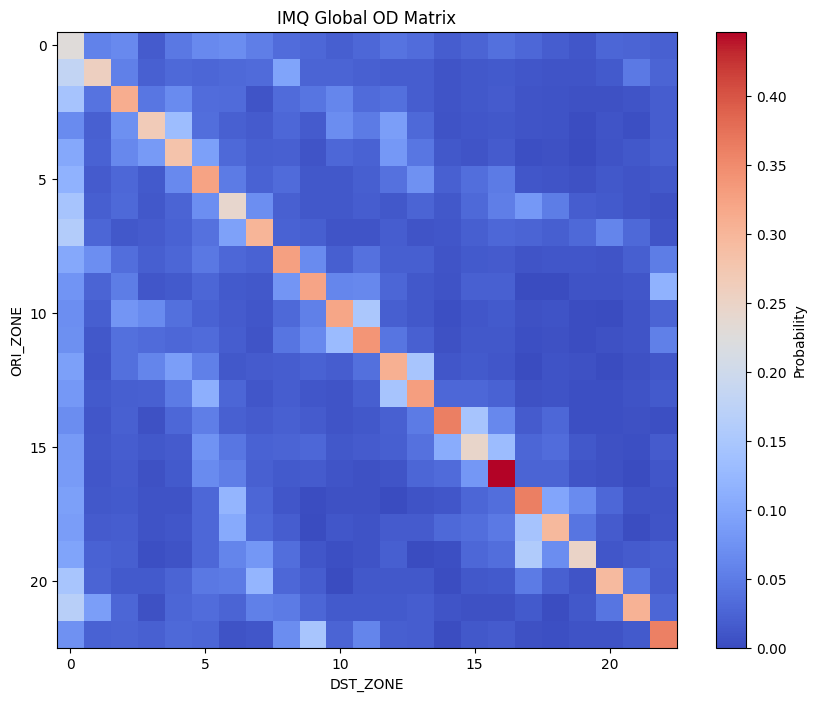

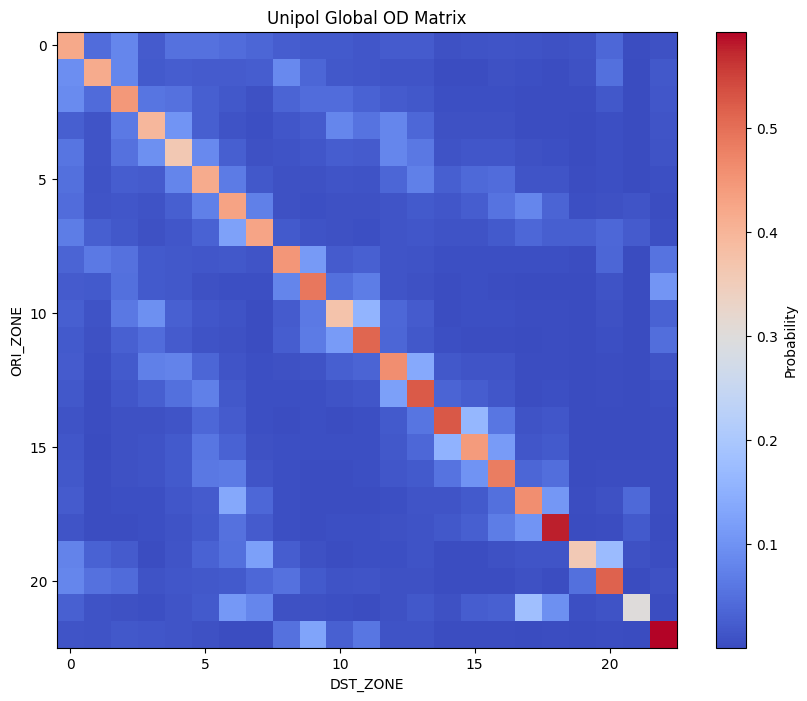

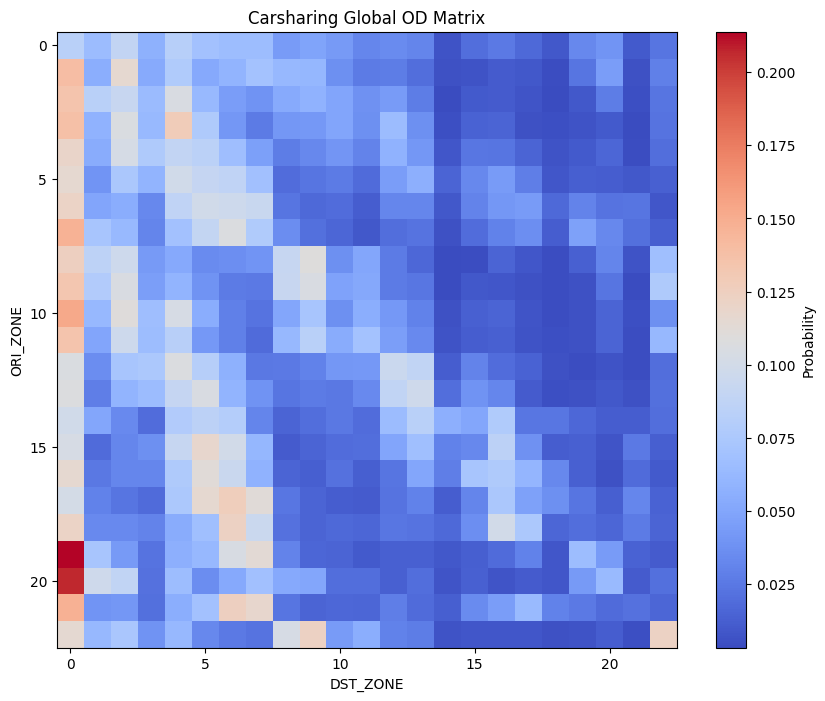

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def normalize_od_matrix(df):
    # Pivot the data to create an OD matrix
    pivot = df.pivot_table(index="ORI_ZONE", columns="DST_ZONE", values="count", fill_value=0)

    # Normalize rows to get probabilities (row sum = 1)
    row_sums = pivot.sum(axis=1).replace(0, np.nan)  # Avoid division by zero
    normalized_matrix = pivot.div(row_sums, axis=0).fillna(0)
    
    return normalized_matrix


# Function to adjust zones to start from 0
def adjust_zones(df):
    if df["ORI_ZONE"].min() > 0:
        df["ORI_ZONE"] -= 1
        df["DST_ZONE"] -= 1
    return df


# Count trips and normalize probabilities
def compute_normalized_od_matrix(df, origin_col, destination_col):
    # Count trips explicitly between each origin and destination
    trip_counts = df.groupby([origin_col, destination_col]).size().reset_index(name="count")

    # Normalize the OD matrix to represent probabilities
    normalized_matrix = normalize_od_matrix(trip_counts)
    return normalized_matrix


# Load and preprocess Car2Go and Enjoy OD data
def load_and_adjust_od_data(file_path):
    reader = pd.read_csv(file_path, chunksize=10000)
    data = pd.concat([chunk for chunk in reader], ignore_index=True)
    return adjust_zones(data)

# Preprocessing function for other datasets
def preprocess_data(imq_data):
    # Adjust zones to start from 0
    imq_data = adjust_zones(imq_data)
    return imq_data


# Load the data (assuming functions to preprocess IMQ and Unipol datasets)
imq_data = preprocess_data(imq_data)

car2go_data = load_and_adjust_od_data("car2go_od_matrix.csv")
enjoy_data = load_and_adjust_od_data("enjoy_od_matrix.csv")

# Combine Car2Go and Enjoy into Carsharing data
carsharing_data = pd.concat([car2go_data, enjoy_data], ignore_index=True)

# Compute global normalized OD matrices
imq_od_global = compute_normalized_od_matrix(imq_data, "ORI_ZONE", "DST_ZONE")
unipol_od_global = compute_normalized_od_matrix(unipol_merged, "ORI_ZONE", "DST_ZONE")
carsharing_od_global = compute_normalized_od_matrix(carsharing_data, "ORI_ZONE", "DST_ZONE")

# Plot the global OD matrices
def plot_od_matrix(matrix, title):
    plt.figure(figsize=(10, 8))
    plt.imshow(matrix, cmap="coolwarm", interpolation="nearest", aspect="auto")
    plt.title(title)
    plt.colorbar(label="Probability")
    plt.xlabel("DST_ZONE")
    plt.ylabel("ORI_ZONE")
    plt.show()

plot_od_matrix(imq_od_global, "IMQ Global OD Matrix")
plot_od_matrix(unipol_od_global, "Unipol Global OD Matrix")
plot_od_matrix(carsharing_od_global, "Carsharing Global OD Matrix")
